In [7]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
Data = np.load('wave_DongHai.npz', encoding='latin1')
waveData = Data['data']
len(waveData)
waveHeight1 = np.zeros(len(waveData))
for i in range(len(waveData)):
    waveHeight1[i] = waveData[i][0][0]
    
waveHeight1.shape

(30187,)

In [17]:
# 浪高数据 wave_heights
wave_heights = waveHeight1 

# 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
wave_heights_scaled = scaler.fit_transform(wave_heights.reshape(-1, 1))

# 设置时间窗口
time_steps = 24
X, y = [], []

for i in range(len(wave_heights_scaled) - time_steps):
    X.append(wave_heights_scaled[i:i + time_steps])
    y.append(wave_heights_scaled[i + time_steps])

X, y = np.array(X), np.array(y)

# 划分训练集和测试集
train_size = int(len(X) * 0.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 4

model = LSTMModel(input_size, hidden_size, output_size, num_layers)


In [36]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.0017
Epoch [2/20], Loss: 0.0074
Epoch [3/20], Loss: 0.0055
Epoch [4/20], Loss: 0.0065
Epoch [5/20], Loss: 0.0115
Epoch [6/20], Loss: 0.0033
Epoch [7/20], Loss: 0.0012
Epoch [8/20], Loss: 0.0019
Epoch [9/20], Loss: 0.0022
Epoch [10/20], Loss: 0.0102
Epoch [11/20], Loss: 0.0047
Epoch [12/20], Loss: 0.0047
Epoch [13/20], Loss: 0.0048
Epoch [14/20], Loss: 0.0010
Epoch [15/20], Loss: 0.0008
Epoch [16/20], Loss: 0.0086
Epoch [17/20], Loss: 0.0055
Epoch [18/20], Loss: 0.0260
Epoch [19/20], Loss: 0.0023
Epoch [20/20], Loss: 0.0041


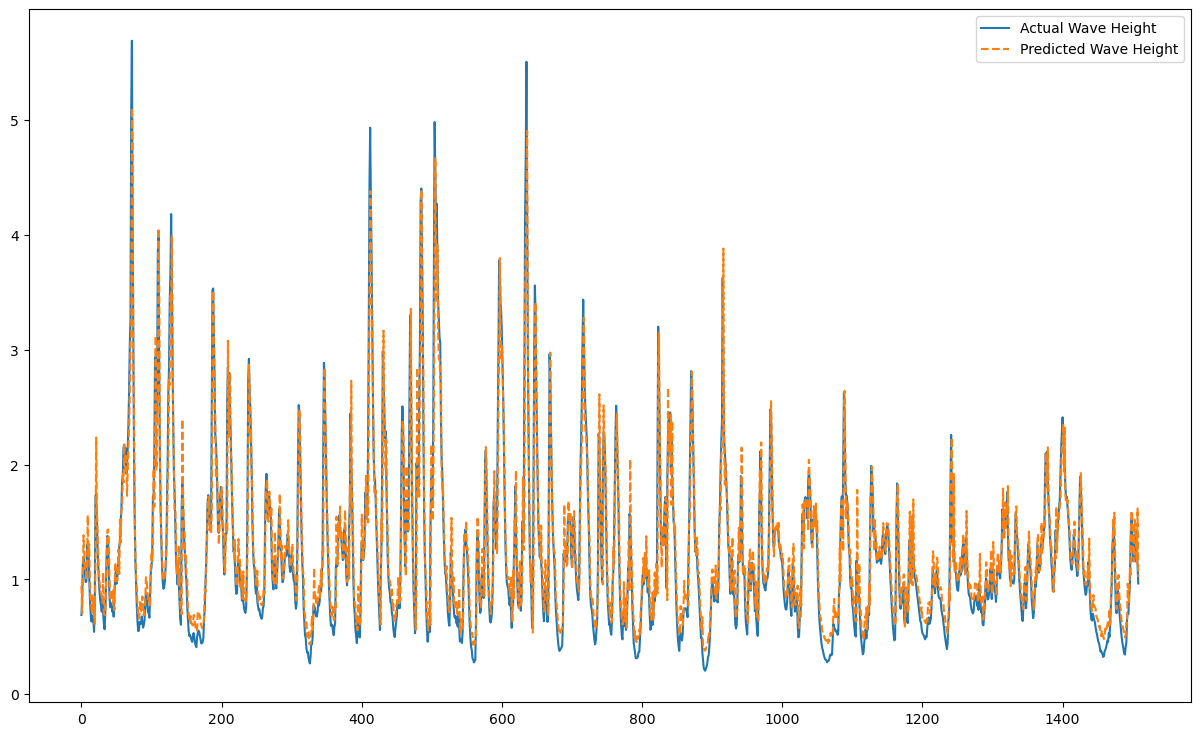

In [38]:
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# 反归一化
y_test_scaled = scaler.inverse_transform(y_test_tensor.numpy())
y_pred_scaled = scaler.inverse_transform(y_pred)

# 打印预测结果

plt.figure(figsize=(15, 9))
plt.plot(y_test_scaled, label='Actual Wave Height')
plt.plot(y_pred_scaled, label='Predicted Wave Height', linestyle='--')
plt.legend()
plt.show()
